# Distributed Task Scheduling with Luigi

![title](img/paper-airplanes-design.png)
https://www.teachthought.com/education/a-really-cool-database-for-paper-airplanes/

![title](img/luigi.png)
https://luigi.readthedocs.io/en/stable/

* Luigi is designed for pipelining tasks together
* Works well with long running batch tasks
* Works well with atomistic tasks
* Can be used to manage distributed tasks
* Works well with databases & [Hadoop](http://hadoop.apache.org/)

## Anatomy of a Luigi task

In [8]:
import luigi
from plot import plot_airplane 

class Airplane(luigi.Task):
    """
    Create a plot of an airplane
    
    Methods
    --------
    requires()
        What prerequiste tasks does this need
    
    run()
        Running the code for the task
    
    output()
        Define output  that defines the task as complete
    """
    def requires(self):
        pass
    
    def run(self):
        plot_airplane(filename="img/plane.png", color='m')
        
    def output(self):
        luigi.LocalTarget("img/plane.png")
        

## Running A Luigi Task

DEBUG: Checking if Airplane() is complete
INFO: Informed scheduler that task   Airplane__99914b932b   has status   PENDING
INFO: Done scheduling tasks
INFO: Running Worker with 1 processes
DEBUG: Asking scheduler for work...
DEBUG: Pending tasks: 1
INFO: [pid 13255] Worker Worker(salt=469172228, workers=1, host=nelse003-MS-7996, username=nelse003, pid=13255) running   Airplane()


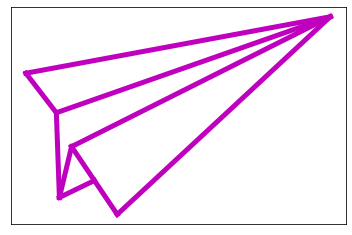

INFO: [pid 13255] Worker Worker(salt=469172228, workers=1, host=nelse003-MS-7996, username=nelse003, pid=13255) done      Airplane()
DEBUG: 1 running tasks, waiting for next task to finish
INFO: Informed scheduler that task   Airplane__99914b932b   has status   DONE
DEBUG: Asking scheduler for work...
DEBUG: Done
DEBUG: There are no more tasks to run at this time
INFO: Worker Worker(salt=469172228, workers=1, host=nelse003-MS-7996, username=nelse003, pid=13255) was stopped. Shutting down Keep-Alive thread
INFO: 
===== Luigi Execution Summary =====

Scheduled 1 tasks of which:
* 1 ran successfully:
    - 1 Airplane()

This progress looks :) because there were no failed tasks or missing dependencies

===== Luigi Execution Summary =====



True

<Figure size 432x288 with 0 Axes>

In [9]:
luigi.build(
    [
       Airplane(), 
            ],
    local_scheduler=True
)

## Central task Scheduler

Luigi has a central scheduler which runs using as [daemon](https://en.wikipedia.org/wiki/Daemon_(computing))

Run `luigid` from activated conda env

DEBUG: Checking if Airplane() is complete
INFO: Informed scheduler that task   Airplane__99914b932b   has status   PENDING
INFO: Done scheduling tasks
INFO: Running Worker with 1 processes
DEBUG: Asking scheduler for work...
DEBUG: Pending tasks: 1
INFO: [pid 13255] Worker Worker(salt=302042390, workers=1, host=nelse003-MS-7996, username=nelse003, pid=13255) running   Airplane()


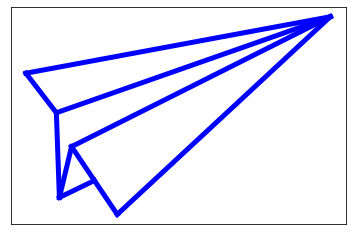

INFO: [pid 13255] Worker Worker(salt=302042390, workers=1, host=nelse003-MS-7996, username=nelse003, pid=13255) done      Airplane()
DEBUG: 1 running tasks, waiting for next task to finish
INFO: Informed scheduler that task   Airplane__99914b932b   has status   DONE
DEBUG: Asking scheduler for work...
DEBUG: Done
DEBUG: There are no more tasks to run at this time
INFO: Worker Worker(salt=302042390, workers=1, host=nelse003-MS-7996, username=nelse003, pid=13255) was stopped. Shutting down Keep-Alive thread
INFO: 
===== Luigi Execution Summary =====

Scheduled 1 tasks of which:
* 1 ran successfully:
    - 1 Airplane()

This progress looks :) because there were no failed tasks or missing dependencies

===== Luigi Execution Summary =====



True

<Figure size 432x288 with 0 Axes>

In [3]:
luigi.build(
    [
       Airplane(), 
            ],
)

##  More Information

[Luigi docs](https://luigi.readthedocs.io/en/stable/)